## Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## let's remove unnecessary warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

## import the model

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### import seasonal decompose

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

### import auto arima

In [5]:
from pmdarima import auto_arima

### Read the data

In [47]:
df=pd.read_csv('co2_mm_mlo.csv')

### EDA

In [48]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [49]:
df1=df.copy()

In [50]:
df1.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


### make dates from given variables

In [51]:
df1['Date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

In [52]:
df1.head()

,year,month,decimal_date,average,interpolated,Date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          729 non-null    int64         
 1   month         729 non-null    int64         
 2   decimal_date  729 non-null    float64       
 3   average       722 non-null    float64       
 4   interpolated  729 non-null    float64       
 5   Date          729 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.3 KB


### Set the index as date

In [54]:
df1=df1.set_index('Date')

In [55]:
df1.head()

,year,month,decimal_date,average,interpolated
Date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


#### remove the unnecessary columns

In [58]:
df1=df1.drop(['year','month'],axis=1)

In [59]:
df1.head()

,decimal_date,average,interpolated
Date,,,
1958-03-01,1958.208,315.71,315.71
1958-04-01,1958.292,317.45,317.45
1958-05-01,1958.375,317.50,317.50
1958-06-01,1958.458,NaN,317.10
1958-07-01,1958.542,315.86,315.86


#### As our data has dates as starting of every month we have to set the freq as such

In [60]:
df1.index.freq='MS'

### Plot the data

<AxesSubplot:xlabel='Date'>

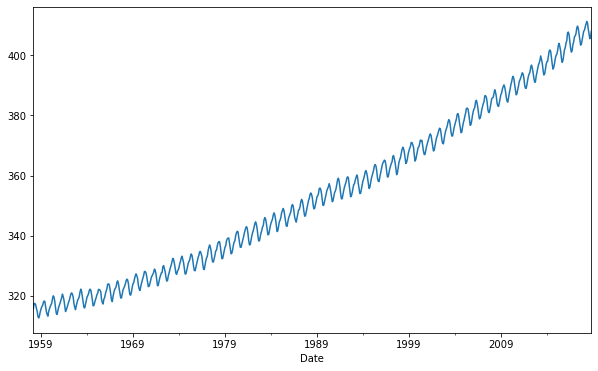

In [61]:
df1['interpolated'].plot(figsize=(10,6))

### let's see ETS decomposition of the data

In [62]:
result=seasonal_decompose(df1['interpolated'],model='add')

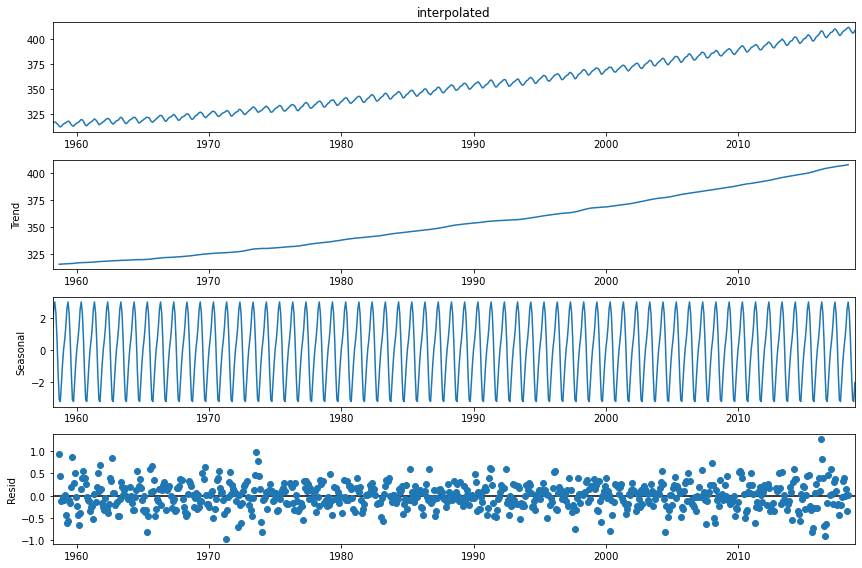

In [66]:
from pylab import rcParams
rcParams['figure.figsize']=12,8
result.plot();

#### we see that there is an upward trend in the data and definitely seasonality as well

#### let's find the particular pdq and PDQ values for the model

In [67]:
auto_arima(df1['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.689
Date:                              Sun, 26 Sep 2021   AIC                            423.378
Time:                                      00:33:03   BIC                            450.920
Sample:                                           0   HQIC                           434.005
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.037     -9.759      0.000      -0.428      -0.285
ma.L2         -0.0222      0.033     -0.668      0.504      -0.087       0.043
ma.L3         -0.0857      0.034     -2.551      0.011      -0.152      -0.020
ar.S.L12       0.9996      0.000   3021.865      0.000       0.999       1.000
ma.S.L12      -0.8663      0.021    -41.119      0.000      -0.908      -0.825
sigma2         0.0955      0.005     20.359      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.04
Prob(Q):                              0.79   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### we find the values as (p,d,q) = (0,1,3) and (P,D,Q) = (1,0,1) and m=12

## Train test split

In [68]:
len(df1)

729

In [69]:
train = df1.iloc[:717]
test = df1.iloc[717:]

### Prepare the model

In [70]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))

#### fit the model

In [71]:
results=model.fit()

In [72]:
start = len(train)
end = len(train)+len(test)-1

#### predict the values for test dataset

In [73]:
predictions=results.predict(start,end,typ='levels').rename('SARIMA Pred')

### plot the test data with predicted values

<AxesSubplot:xlabel='Date'>

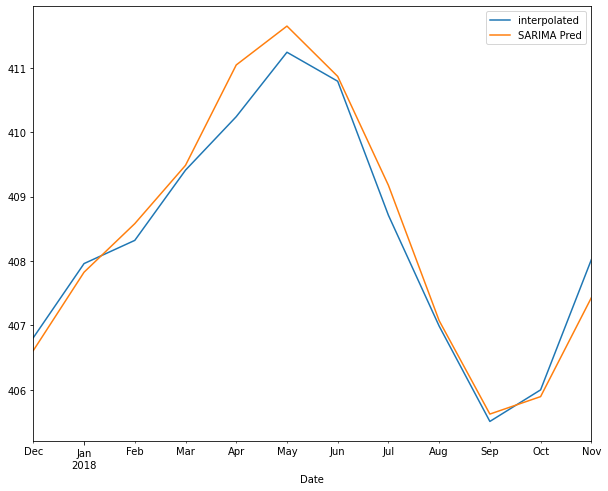

In [77]:
test['interpolated'].plot(figsize=(10,8),legend=True)
predictions.plot(legend=True)

#### perform quantitave evaluation as well

In [78]:
from statsmodels.tools.eval_measures import rmse

In [79]:
rmse(test['interpolated'],predictions)

0.35841102362581284

In [80]:
test['interpolated'].mean()

408.3333333333333

## forecast for future

In [81]:
model = SARIMAX(df1['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))

In [82]:
results=model.fit()

In [84]:
start = len(df)
end = len(df)+11

In [85]:
fcasts=results.predict(start,end,typ='levels').rename('SARIMA forecast')

### Plot forecasted values

<AxesSubplot:xlabel='Date'>

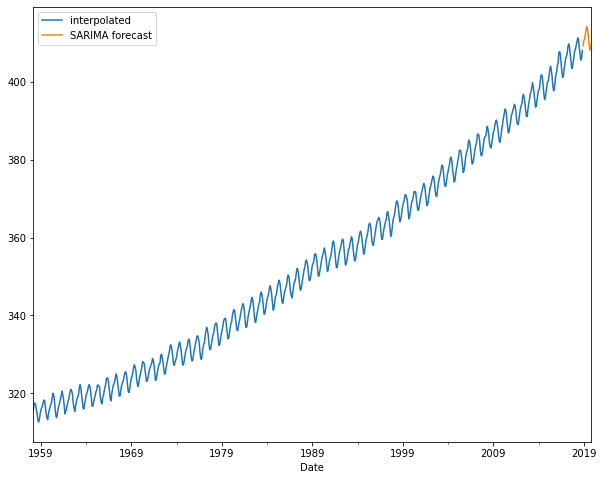

In [86]:
df1['interpolated'].plot(figsize=(10,8),legend=True)
fcasts.plot(legend=True)

<AxesSubplot:xlabel='Date'>

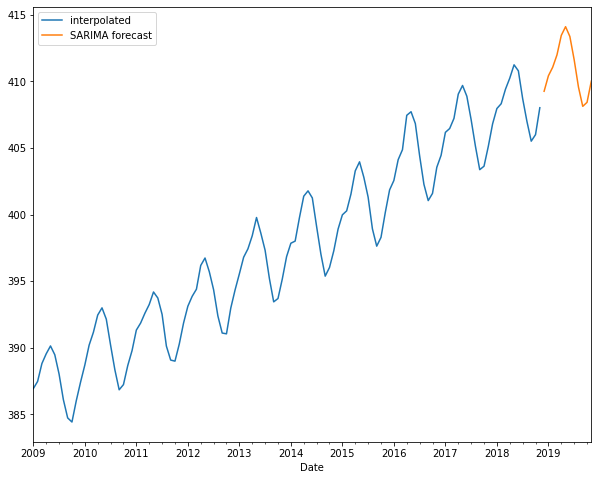

In [87]:
df1['interpolated']['2009-01-01':].plot(figsize=(10,8),legend=True)
fcasts.plot(legend=True)